[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](
https://colab.research.google.com/github/Priesemann-Group/covid19_inference/blob/pymc4/scripts/interactive/example_bundeslaender.ipynb)

In [ ]:
#optional (if not cloned i.e. running in colab)
# !pip install covid19_inference

# Hierarchical Bayesian Model for all German states (Bundeslaender).

**Attention! This notebook is experimental and uses some features of the package that have not been thoroughly tested! Please interpret the results with caution.**

Runtime ~ 1h

Check the `example_one_bundesland.ipynb` for an example on how to get started with the package.


## Importing modules

In [1]:
import datetime
import sys
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.stats
import pymc as pm

In [2]:
try:
    import covid19_inference as cov19
except ModuleNotFoundError:
    sys.path.append("../../")
    import covid19_inference as cov19



## Creating the model

This cell downloads data and builds the pymc3 model for the Bayesian inference.
More information can be found in the
[documentation](https://covid19-inference.readthedocs.io/en/latest/doc/gettingstarted.html).


In [3]:
# Dates to obtain the data from
date_begin_data = datetime.datetime(2020, 3, 10)
date_end_data = datetime.datetime(2020, 4, 19)

In [4]:
# Downloads 2-D array of new cases (for each state) from the Robert Koch Institute
rki = cov19.data_retrieval.RKI(True)
df_bundeslaender = rki.filter_all_bundesland(date_begin_data, date_end_data)
new_cases_obs = np.diff(np.array(df_bundeslaender), axis=0)[:, :]

INFO     [covid19_inference.data_retrieval.retrieval] Successfully downloaded Rki.csv.gz to /tmp/covid19_data/.
INFO     [covid19_inference.data_retrieval.retrieval] Local backup to /tmp/covid19_data/Rki.csv.gz successful.


In [5]:
# 1D array of state population, ordered alphabetically
N_state = [
    10880000,
    12844000,
    3520000,
    2485000,
    671000,
    1787000,
    6176000,
    7927000,
    1612000,
    17865000,
    4053000,
    996000,
    4085000,
    2245000,
    2859000,
    2171000,
]

In [10]:
# Number of days the simulation starts earlier than the data.
# Should be significantly larger than the expected delay in order to always fit the same number of data points.
diff_data_sim = 16
# Number of days in the future (after date_end_data) to forecast cases
num_days_forecast = 10

In [11]:
# Change point midpoint dates
prior_date_mild_dist_begin = datetime.datetime(2020, 3, 11)
prior_date_strong_dist_begin = datetime.datetime(2020, 3, 18)
prior_date_contact_ban_begin = datetime.datetime(2020, 3, 25)

In [12]:
# Structures change points in a dict. Variables not passed will assume default values.
change_points = [
    dict(
        pr_mean_date_transient=prior_date_mild_dist_begin,
        pr_sigma_date_transient=1.5,
        pr_median_lambda=0.2,
        pr_sigma_lambda=0.5,
        pr_sigma_transient_len=0.5,
    ),
    dict(
        pr_mean_date_transient=prior_date_strong_dist_begin,
        pr_sigma_date_transient=1.5,
        pr_median_lambda=1 / 8,
        pr_sigma_lambda=0.5,
        pr_sigma_transient_len=0.5,
    ),
    dict(
        pr_mean_date_transient=prior_date_contact_ban_begin,
        pr_sigma_date_transient=1.5,
        pr_median_lambda=1 / 8 / 2,
        pr_sigma_lambda=0.5,
        pr_sigma_transient_len=0.5,
    ),
]

In [13]:
# Stores the model parameters in a dict
params_model = dict(
    new_cases_obs=new_cases_obs[:],
    data_begin=date_begin_data,
    fcast_len=num_days_forecast,
    diff_data_sim=diff_data_sim,
    N_population=N_state,
)
# Median of the prior for the delay in case reporting, we assume 10 days
pr_delay = 10

In [14]:
# The true model is defined in a context manager.
# Check https://docs.pymc.io/notebooks/getting_started.html for details on it.
with cov19.model.Cov19Model(**params_model) as this_model:

    # Create the array of the time dependent infection rate lambda
    lambda_t_log = cov19.model.lambda_t_with_sigmoids(
        pr_median_lambda_0=0.4,
        pr_sigma_lambda_0=0.5,
        change_points_list=change_points,
        name_lambda_t="lambda_t",  # Name for the variable in the trace (see later)
    )

    # Adds the recovery rate mu to the model as a random variable
    mu = pm.Lognormal(name="mu", mu=np.log(1 / 8), sigma=0.2)

    # This builds a decorrelated prior for I_begin for faster inference. It is not
    # necessary to use it, one can simply remove it and use the default argument for
    # pr_I_begin in cov19.SIR
    prior_I = cov19.model.uncorrelated_prior_I(
        lambda_t_log=lambda_t_log, mu=mu, pr_median_delay=pr_delay
    )

    # Use lambda_t_log and mu as parameters for the SIR model.
    # The SIR model generates the inferred new daily cases.
    new_cases = cov19.model.SIR(lambda_t_log=lambda_t_log, mu=mu, pr_I_begin=prior_I)

    # Delay the cases by a lognormal reporting delay and add them as a trace variable
    new_cases = cov19.model.delay_cases(
        cases=new_cases,
        name_cases="delayed_cases",
        pr_mean_of_median=pr_delay,
        pr_median_of_width=0.3,
    )

    # Modulate the inferred cases by a abs(sin(x)) function, to account for weekend effects
    # Also adds the "new_cases" variable to the trace that has all model features.
    new_cases = cov19.model.week_modulation(cases=new_cases, name_cases="new_cases")

    # Define the likelihood, uses the new_cases_obs set as model parameter
    cov19.model.student_t_likelihood(cases=new_cases)

INFO     [covid19_inference.model.spreading_rate] Lambda_t with sigmoids
INFO     [covid19_inference.model.model] pr_median_transient_len was set to default value 4
INFO     [covid19_inference.model.model] relative_to_previous was set to default value False
INFO     [covid19_inference.model.model] pr_factor_to_previous was set to default value 1
INFO     [covid19_inference.model.model] pr_median_transient_len was set to default value 4
INFO     [covid19_inference.model.model] relative_to_previous was set to default value False
INFO     [covid19_inference.model.model] pr_factor_to_previous was set to default value 1
INFO     [covid19_inference.model.model] pr_median_transient_len was set to default value 4
INFO     [covid19_inference.model.model] relative_to_previous was set to default value False
INFO     [covid19_inference.model.model] pr_factor_to_previous was set to default value 1
INFO     [covid19_inference.model.compartmental_models] Uncorrelated prior_I
INFO     [covid19_inferen



## MCMC sampling

After the model is built, it is sampled using an MCMC sampler.
The number of parallel runs can be set with the argument `cores=`.
The sampling can take a long time.


In [15]:
idata = pm.sample(model=this_model, tune=1000, draws=1000, init="advi+adapt_diag",cores=4, chains=4)

INFO     [/data.nst/smohr/anaconda3/envs/test_inf/lib/python3.10/site-packages/aesara/link/c/lazylinker_c.py] Compiling new CVM
INFO     [/data.nst/smohr/anaconda3/envs/test_inf/lib/python3.10/site-packages/aesara/link/c/lazylinker_c.py] New version 0.212
Auto-assigning NUTS sampler...
INFO     [pymc] Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
INFO     [pymc] Initializing NUTS using advi+adapt_diag...


Convergence achieved at 63600
INFO     [pymc.variational.inference] Convergence achieved at 63600
Interrupted at 63,599 [31%]: Average Loss = 3,967.3
INFO     [pymc.variational.inference] Interrupted at 63,599 [31%]: Average Loss = 3,967.3
Multiprocess sampling (4 chains in 4 jobs)
INFO     [pymc] Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_lambda_0_hc_L1_log_exp, lambda_0_hc_L1_log_, lambda_0_hc_L2_log_raw_, sigma_lambda_1_hc_L1_log_exp, lambda_1_hc_L1_log, lambda_1_hc_L2_log_raw_, sigma_lambda_2_hc_L1_log_exp, lambda_2_hc_L1_log, lambda_2_hc_L2_log_raw_, sigma_lambda_3_hc_L1_log_exp, lambda_3_hc_L1_log, lambda_3_hc_L2_log_raw_, sigma_transient_day_1_L1_log_exp, transient_day_1_hc_L1, transient_day_1_hc_L2_raw_, sigma_transient_day_2_L1_log_exp, transient_day_2_hc_L1, transient_day_2_hc_L2_raw_, sigma_transient_day_3_L1_log_exp, transient_day_3_hc_L1, transient_day_3_hc_L2_raw_, sigma_transient_len_1_log_exp, transient_len_1_hc_L1_raw, transient_len_1_hc_L2_raw_raw_, sigma

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 6874 seconds.
INFO     [pymc] Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 6874 seconds.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR    [pymc] There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR    [pymc] There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
There were 92 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR    [pymc] There were 92 divergences after tuning. Increase `target_accept` or reparameterize.
There were 32 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR    [pymc] There were 32 divergences after tuning. Increase `target_accept` or reparameterize.


# Plotting

We below plot the posterior distributions of selected parameters,
and the resulting number of cases for each state.

### Variables

The model uses a large number of parameters, and internally creates new versions
(e.g. var_log_) for handling. All defined parameters can be found in the inference data object `idata`.
See the arviz [documentation](https://arviz-devs.github.io/arviz/getting_started/XarrayforArviZ.html#xarray-for-arviz) for a indepth explanation.

### Violin plots


In [45]:
# Defines plotted variables, their names and plotting range
var_names = {
    "I_begin": {"name": r"$I_0$", "xlim": [0, 300]},
    "lambda_0_hc_L2": {"name": r"$\lambda_0$", "xlim": [0, 1]},
    "lambda_1_hc_L2": {"name": r"$\lambda_1$", "xlim": [0, 1]},
    "lambda_2_hc_L2": {"name": r"$\lambda_2$", "xlim": [0, 1]},
    "lambda_3_hc_L2": {"name": r"$\lambda_3$", "xlim": [0, 1]},
    "transient_day_1_hc_L2": {"name": r"$t_1$", "xlim": [10, 40]},
    "transient_day_2_hc_L2": {"name": r"$t_2$", "xlim": [10, 40]},
    "transient_day_3_hc_L2": {"name": r"$t_3$", "xlim": [30, 60]},
}

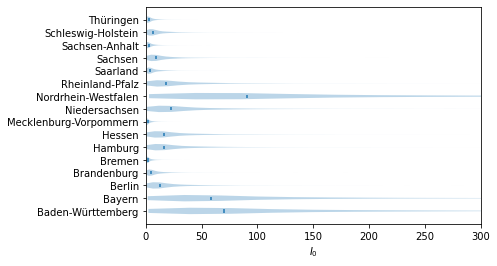

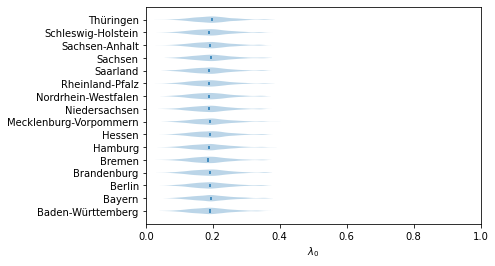

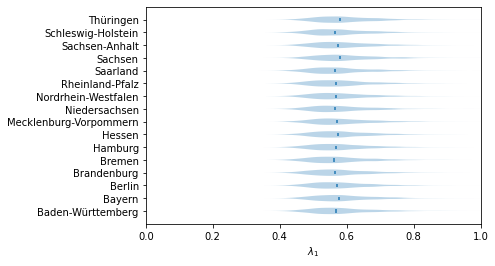

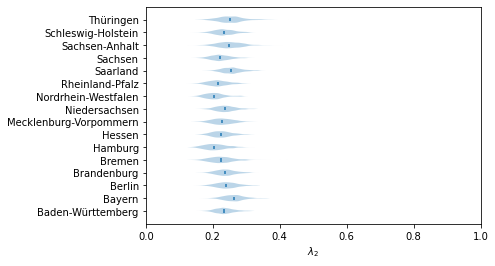

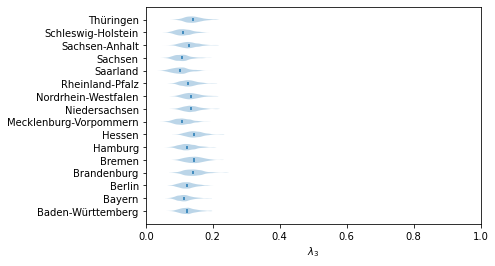

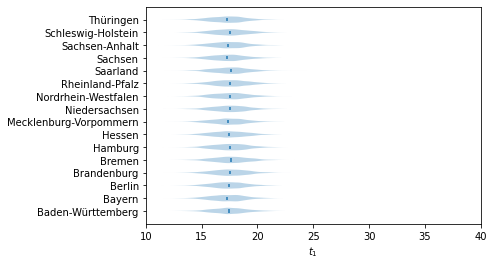

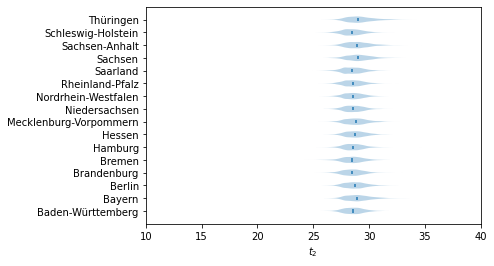

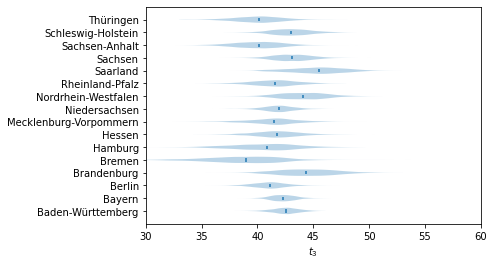

In [46]:
# Plots violin plots
for var_name in var_names.keys():
    f, ax = plt.subplots()
    posterior_samples = cov19.plot.utils.get_array_from_idata(idata,var_name)
    ax.violinplot(posterior_samples, showextrema=False, vert=False, showmedians=True)
    ax.set_yticks(np.arange(1, 17))
    ax.set_yticklabels(df_bundeslaender.columns)
    ax.set_xlabel(var_names[var_name]["name"])
    ax.set_xlim(var_names[var_name]["xlim"])



### Timeseries

For every region (bundesland) we create a timeseries plot. For now new cases! TODO more


In [52]:
# First define the x range on which we want to plot. Should be within the simulation period.
bd = datetime.datetime(2020, 3, 10)
ed = datetime.datetime(2020, 4, 19) + datetime.timedelta(days=num_days_forecast - 1)

In [53]:
# Next we have to get our trace corresponding to that date range. We do that by calling the helper function `cov19.plot._get_array_from_trace_via_date()`.
y_all_regions, x = cov19.plot.utils.get_array_from_idata_via_date(
    this_model, idata, "new_cases", bd, ed
)

In [68]:
%%capture
# After retrieving the trace var for our specified time period, we plot the timeseries for each region. Additionaly we set the format of the date (x-)axis.
# We have 16 regions in this example -> we create 16 subplots
fig, axes = plt.subplots(16, 1, figsize=(10, 35), gridspec_kw={"hspace":0.5});

In [69]:
for i in range(16):
    y = y_all_regions[:, :, i]
    cov19.plot.timeseries._timeseries(x, y, axes[i], what="fcast")
    axes[i].set_title(df_bundeslaender.columns[i])
    #cov19.plot._format_date_xticks(axes[i])

In [70]:
# Furthermore, we can plot our observable i.e. our new_cases_obs.
x_dat = pd.date_range(this_model.data_begin, this_model.data_end)
for i in range(16):
    y = new_cases_obs[:, i]
    cov19.plot.timeseries._timeseries(x_dat, y, axes[i], what="data", lw=0)

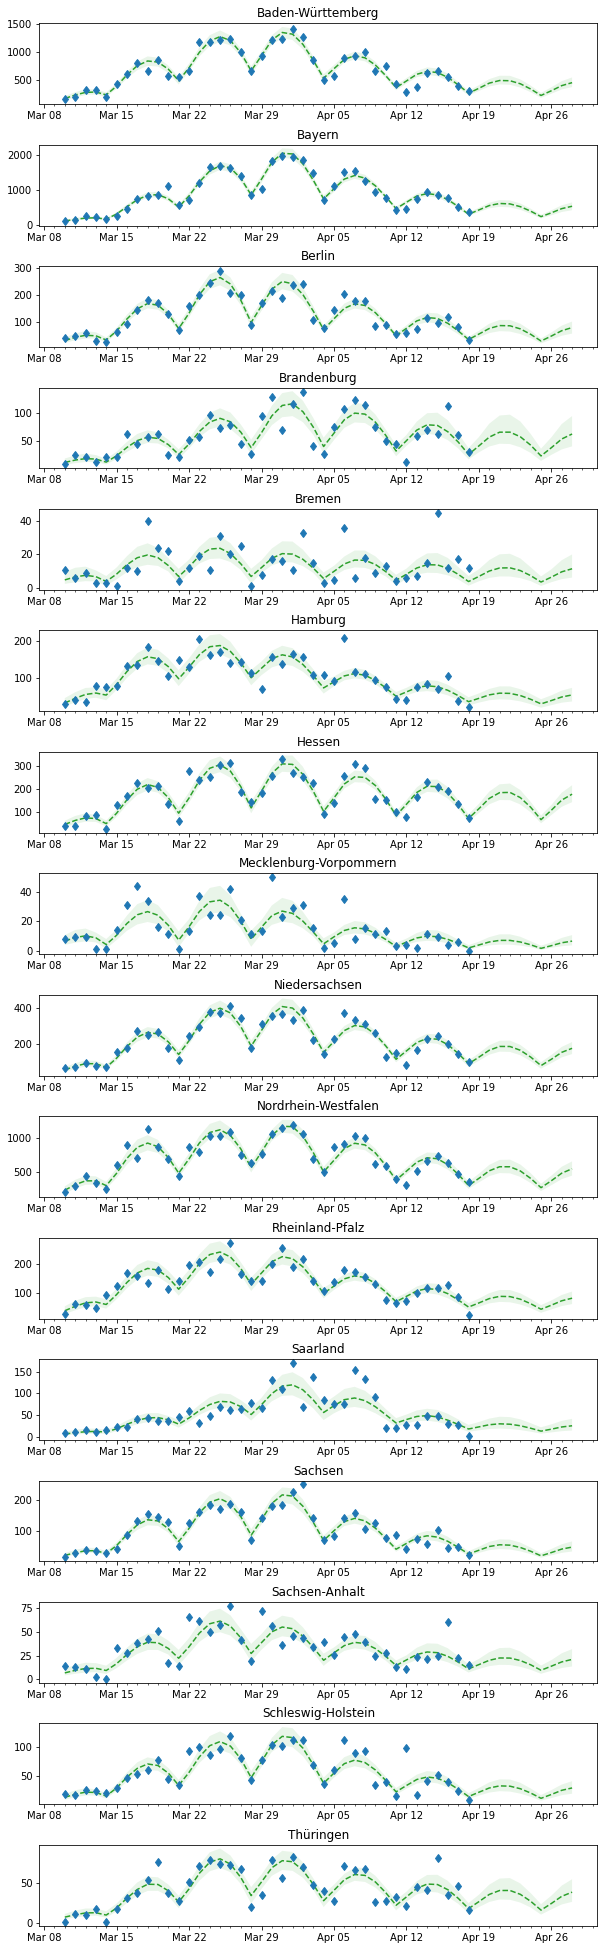

In [71]:
#plt.tight_layout()
fig  # To show figure in jupyter notebook

In [9]:
%load_ext watermark
%watermark --iversions -v

Python implementation: CPython
Python version       : 3.10.5
IPython version      : 8.4.0

numpy            : 1.23.0
pandas           : 1.4.3
covid19_inference: 0.4.0
scipy            : 1.8.1
sys              : 3.10.5 | packaged by conda-forge | (main, Jun 14 2022, 07:06:46) [GCC 10.3.0]
pymc             : 4.0.1
matplotlib       : 3.5.2

